In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ae1a755d-e162-4f07-9f5a-130d2280e78e', project_access_token='p-aa90b9b21de435c3f4c94494a24b5c5e69d030f8')
pc = project.project_context


# Classifying emotions in movie dialogue using Watson NLP - pre-trained models

This notebook demonstrates how to classify emotions in tweets using Watson NLP python library

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebook shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). This block performs tokenization, lemmatization, parts of speech tagging, and dependency parsing on raw input documents so that custom models can properly classify documents.
- **Emotion classification** with the _Ensemble emotion workflow_ (`ensemble_classification-wf_en_emotion-stock`) and the _Aggregated emotion workflow_ (`aggregated_classification-wf_en_emotion-stock`). These model workflow classify text into five emotions: "sadness", "joy", "anger", "fear", "disgust".

## Table of Contents

1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing](#dataProcessing)
    1. [Data formatting](#dataFormat)
    1. [Train test split](#trainTestSplit) 
1. [Running pretrained models](#pretrainedOOTB)
    1. [Emotion model](#ensemble)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import watson_nlp
import watson_nlp.data_model as dm

from sklearn.model_selection import train_test_split

from watson_core.toolkit import fileio
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

from watson_nlp.blocks.classification.bert import BERT
from watson_nlp.blocks.classification.cnn import CNN
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStream
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.blocks.vectorization.tfidf import TFIDF

In [3]:
pd.set_option('display.max_colwidth', 0)

<span style="color:maroon">Printing either `block_models` or `workflow_models` will display a list of pretrained models available in the current version of Watson NLP</span>

In [4]:
block_models = watson_nlp.get_models().get_alias_models()
workflow_models = watson_nlp.get_workflows().get_alias_models()

<a id="loadData"></a>
## 2. Data Loading

The dataset contains over seven thousand quotations from tweets. The labeled emotions in the dataset are "anger", "sadness", "fear", "joy", and "disgust". Because some quotations have multiple sentences, they can be regarded as documents. The dataset is available internally at [Github Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Emotion-Classification/emotion_tweets.csv). The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv) with a CC0: Public Domain license.
<br><br>
Any other emotion classification dataset may be used in substitution for the workflow outlined in this notebook.

Data format:
- .csv file that is loaded as a Pandas DataFrame with two columns, `text` and `label`

Data dictionary:
- text: string; text of tweets; this will be used as the input for models
- label: string; emotion class labels; this will be the what the model is trying to accurately predict

In [6]:
# load data set into a dataframe
buffer = project.get_file("emotion-tweets.csv")
df = pd.read_csv(buffer)

<a id="dataProcessing"></a>
## 3. Data Processing

<a id="dataFormat"></a>
### 3.1. Data formatting

<span style="color:blue">Data prepared for Watson NLP models need to be formatted in such a way that there is a `text` feature column and a `labels` label column. The `labels` column needs have type `list`.</span>

In [7]:
def convertToList(x):
    return [x]

In [8]:
df['label'] = df['label'].apply(convertToList)
df = df.rename(columns={'label':'labels'})

<a id="trainTestSplit"></a>
### 3.2. Train Test Split

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out emotion analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>
<br>

<span style="color:blue">The data will be split into an 80/20 train-test split using sklearn and then exported into JSON format for the Watson NLP models to consume. Additionally, the column headers will be renamed to the expected `text` and `labels` names, with the labels having type list.</span>

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [10]:
df_train.to_json('df_train.json', orient='records')
df_test.to_json('df_test.json', orient='records')

In [11]:
df_train

,text,labels
378,@RobRiggle @joelmchale @NFLonFOX I still can't get jimmy garoppolo out of my head and it's been almost 3 weeks. Thanks a lot!,[joy]
2790,pray for my boy huff,[anger]
3652,"@TurtleTitan2003 (She laughed a bit. Of course it was! Aria shook her head, calming her mirth so she could listen to Mikey.) No, actually. +",[joy]
6211,"Going off reports on Sky, Stoke played ok tonight. Think i'll stay off the messageboard tonight though -it will be grim on there :/",[sadness]
484,Possible magazines over against put with versus thy joviality conjunction shower quotient sufficiently: BQAvtja,[joy]
...,...,...
6984,Might just leave and aggravate bae,[anger]
4293,So I survived spin....trying to get down the stairs was hilarious tho #jellylegs 😂😂,[joy]
4716,the day they disclosed they caught her googling cholroform we were fucking aghast,[fear]
5782,@HotpointUK 'customer service ' beyond appalling. Faulty dryer replacement breaks within wks no parts for 3 wks. Engineers no show.,[anger]


<a id="pretrainedOOTB"></a>
## 4. Running pretrained models
<span style="color:blue">Watson NLP has two pretrained/prebuilt emotion classificaiton models using the workflow system. 
The following examples will use *\"Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me.\"* as a single input test with the expected label to be *\"joy\"*.</span>

<a id="ensemble"></a>
### Ensemble emotion model
<br>
<span style="color:blue">Ensemble emotion model will perform document emotion classification. [Docs](https://pages.github.ibm.com/ai-foundation/watson-nlp-documentation/workflow_emotion_classification.html)</span>

In [88]:
# Load the Emotion workflow model for English
emotion_model = watson_nlp.load(watson_nlp.download('emotion_aggregated-workflow_en_stock'))

./build/lib/watson_nlp/workflows/classification/ensemble.py:196: DeprecationWarning: Call to deprecated class Ensemble. (The `Ensemble` class will be deprecated in next major release. Please try using the new `watson_nlp.workflows.classification.GenericEnsemble` class instead. We will continue to provide backwards compatibility for models trained with this `Ensemble` class) -- Deprecated since version 4.0.0.


<span style="color:blueviolet">The result of the Ensemble model returns a list of dictionaries that indicate each label and its confidence score. The highest confidence score deems the label of prediction.</span>

In [15]:
# Run the Emotion model on a single document
emotion_result = emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ")
print(emotion_result)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.08250845323441401,
        "disgust": 0.016781293316109277,
        "fear": 0.060853523846089226,
        "joy": 0.4856539209058151,
        "sadness": 0.12966796558237437
      },
      "target": "",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 17,
            "text": "Such a sweet boy."
          },
          "emotion": {
            "anger": 0.013534160558430649,
            "disgust": 0.004069027115209876,
            "fear": 0.010137621332846307,
            "joy": 0.9775093739682978,
            "sadness": 0.04513222549223539
          }
        },
        {
          "span": {
            "begin": 18,
            "end": 153,
            "text": "But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be..."
          },
          "emotion": {
            "anger": 0.16116835041479

<span style="color:blueviolet">The Ensemble model also has the `model.evaluate_quality()` function, which allows the evaluation of an entire test set. The result returns a dictionary of dictionaries that map each label to its confusion matrix, precision and recall, and f1 score.</span>

In [16]:
test_data_file = "df_test.json"

quality_report = emotion_model.evaluate_quality(test_data_file)
print(json.dumps(quality_report, indent=4))

{
    "per_class_confusion_matrix": {
        "sadness": {
            "true_positive": 174,
            "false_positive": 272,
            "false_negative": 132,
            "precision": 0.3901345291479821,
            "recall": 0.5686274509803921,
            "f1": 0.46276595744680854
        },
        "anger": {
            "true_positive": 89,
            "false_positive": 56,
            "false_negative": 259,
            "precision": 0.6137931034482759,
            "recall": 0.2557471264367816,
            "f1": 0.36105476673427994
        },
        "fear": {
            "true_positive": 123,
            "false_positive": 46,
            "false_negative": 331,
            "precision": 0.727810650887574,
            "recall": 0.2709251101321586,
            "f1": 0.39486356340288925
        },
        "joy": {
            "true_positive": 257,
            "false_positive": 355,
            "false_negative": 56,
            "precision": 0.4199346405228758,
            "recall": 0

Based on the micro precision, recall, and f1 score, this Ensemble model did not perform well on our test data. However hyperparameter tuning of the pre-trained model may improve its performance.
<br><br>
*The micro metrics are taken here instead of the macro metrics because of the class imbalance in the data.

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [73]:
def run_emotion(text):
    emotion_result = emotion_model.run(text)
    #help(emotion_result.emotion_predictions[0].emotion)
    return emotion_result.emotion_predictions[0].emotion.to_dict()

In [18]:
test_df = pd.read_json(test_data_file)
test_df['label'] = test_df['labels'].str[0]
test_df['label'] = test_df['label'].replace({'happiness':'joy'})

In [74]:
output = []
for line in test_df['text']:
    output.append([line, run_emotion(line)])

In [83]:
emotion_df = pd.DataFrame(output, columns=['text', 'emotions'])
emotion_df = pd.concat([emotion_df, emotion_df["emotions"].apply(pd.Series)], axis=1)
emotion_df = emotion_df.drop(['emotions'], axis=1)
emotion_df['highest_emotion'] = emotion_df[['anger', 'disgust', 'fear', 'joy', 'sadness']].idxmax(axis=1)
emotion_df

,text,anger,disgust,fear,joy,sadness,highest_emotion
0,I hope my hustle don't offend nobody,0.070598,0.064689,0.095394,0.032086,0.607643,sadness
1,@charles_gaba @NateSilver538 @DavMicRot @FiveThirtyEight A litany of name-calling. How dull.,0.037618,0.077156,0.062490,0.378703,0.413911,sadness
2,Right i may be an #sufc fan and the football maybe shit but marcos rojo for #mufc has had a shocking start he's just dreadful,0.437432,0.277860,0.100173,0.006432,0.138271,anger
3,He's intimidated by my work ethic I think he knows I want his spot 🤔😉😂😂,0.062003,0.084426,0.445752,0.083973,0.111409,fear
4,@AllredMD @KerryCallen @thismanthispete Kirby's Black Panther in a cool animated panel.,0.015538,0.012702,0.033327,0.593795,0.089334,joy
...,...,...,...,...,...,...,...
1416,@bolain_branden @GrimsToyShow grim should find broken Matt hardy because he can delete everything lol,0.051286,0.244470,0.482605,0.018281,0.224427,fear
1417,OOOOOOOOH MY GOD UUUUGGGGHHHHHHHHH #rage,0.494773,0.039164,0.078011,0.304176,0.069942,anger
1418,"God, I've been so physically weak the whole day. So much shaking :(",0.060083,0.023595,0.394856,0.088114,0.652688,sadness
1419,@MarkTOByrne I offered @WholeFoods @amazon @CheapAir gold or silver but they said Nah... #bitcoin #snap,0.056611,0.038070,0.064140,0.476529,0.214435,joy


Text(0.5, 1.0, 'Test dataset labels')

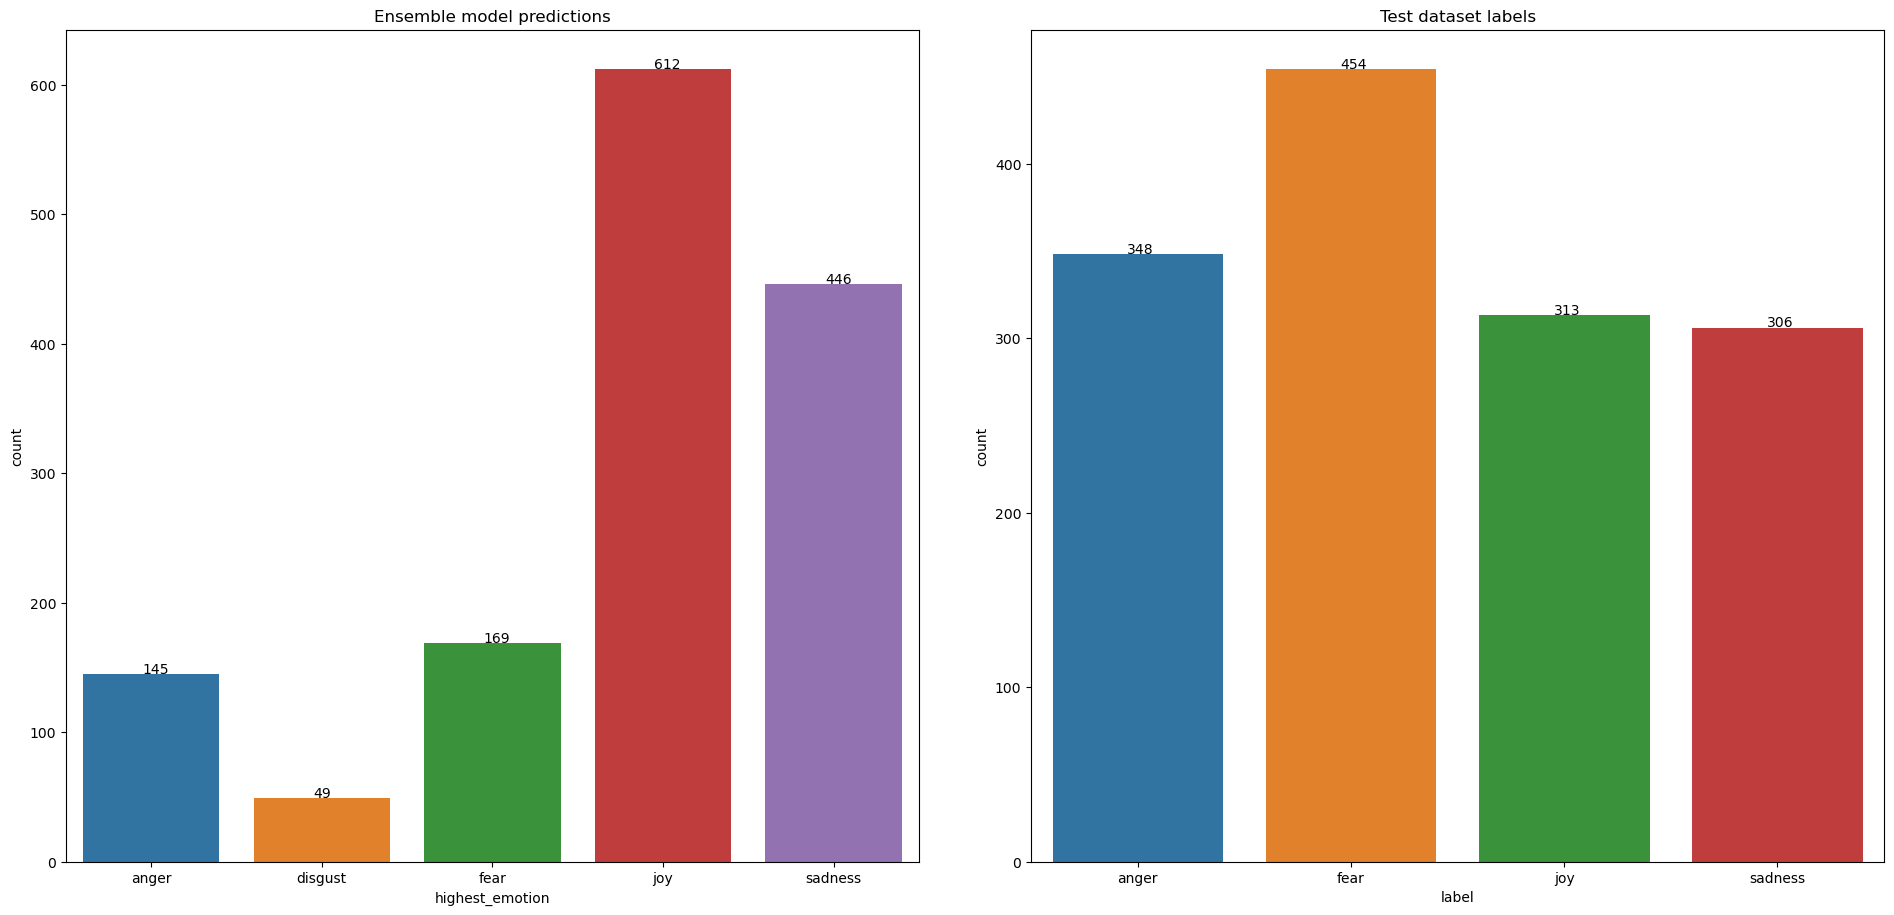

In [84]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=emotion_df['highest_emotion'],  data=emotion_df['highest_emotion'], order=emotion_df['highest_emotion'].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, emotion_df['highest_emotion'].value_counts().sort_index()): 
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Emotion model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for emotion analysis.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub](https://github.com/ibm-build-labs/Watson-NLP) repository. 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 